In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adv-pathbaseline-model/tensorflow2/default/1/best_model.keras
/kaggle/input/adv-pathbaseline-model/tensorflow2/default/1/metrics_baseline.json
/kaggle/input/adv-pathbaseline-model/tensorflow2/default/1/fgsm_adv_art.npy


In [2]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random


# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


# Paths (modify if needed)
ADV_PATH = "/kaggle/input/adv-pathbaseline-model/tensorflow2/default/1/fgsm_adv_art.npy"
BASELINE_MODEL_PATH = "/kaggle/input/adv-pathbaseline-model/tensorflow2/default/1/best_model.keras"
BASELINE_METRICS_PATH = "/kaggle/input/adv-pathbaseline-model/tensorflow2/default/1/metrics_baseline.json"
OUT_DIR = "/kaggle/working/defense_outputs"
os.makedirs(OUT_DIR, exist_ok=True)


print("Saved outputs will go to:", OUT_DIR)


2025-11-22 06:48:11.119138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763794091.336380      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763794091.397804      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Saved outputs will go to: /kaggle/working/defense_outputs


In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


# Normalize & add channel dimension
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)


# Load adversarial samples
if not os.path.exists(ADV_PATH):
    raise FileNotFoundError(f"FGSM adversarial file NOT FOUND at {ADV_PATH}. Generate in Notebook 2 first.")


x_adv = np.load(ADV_PATH).astype('float32')
if x_adv.ndim == 3:
    x_adv = np.expand_dims(x_adv, -1)


n_adv = len(x_adv)
y_adv = y_test[:n_adv]
print("Adversarial:", x_adv.shape, y_adv.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 28, 28, 1) (60000,)
Test : (10000, 28, 28, 1) (10000,)
Adversarial: (200, 28, 28, 1) (200,)


In [4]:
NUM_CLASSES = 10
y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_adv_cat = keras.utils.to_categorical(y_adv, NUM_CLASSES)


X_combined = np.concatenate([x_train, x_adv], axis=0)
Y_combined = np.concatenate([y_train_cat, y_adv_cat], axis=0)


print("Combined dataset shape:", X_combined.shape, Y_combined.shape)
print("Adversarial proportion:", len(x_adv) / len(X_combined))


Combined dataset shape: (60200, 28, 28, 1) (60200, 10)
Adversarial proportion: 0.0033222591362126247


In [5]:
from tensorflow import keras as _keras


def make_cnn_model(input_shape=(28, 28, 1), num_classes=10):
    layers = _keras.layers
    model = _keras.Sequential([
# Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
# Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
# Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
# Dense
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name='Improved_MNIST_CNN_V1')
    return model


model_def = make_cnn_model()
model_def.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763794108.808100      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763794108.808865      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "Improved_MNIST_CNN_V1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,929,834 (7.36 MB)

 Trainable params: 1,928,170 (7.36 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [6]:
model_def.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
loss=keras.losses.CategoricalCrossentropy(),
metrics=['accuracy'])


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


callbacks = [
EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
ModelCheckpoint(os.path.join(OUT_DIR, 'defended_best.keras'), save_best_only=True, monitor='val_accuracy')
]


history_def = model_def.fit(
X_combined, Y_combined,
validation_split=0.1,
batch_size=128,
epochs=15,
callbacks=callbacks,
verbose=2
)


model_def.save(os.path.join(OUT_DIR, 'defended_model.keras'))
with open(os.path.join(OUT_DIR, 'defended_history.json'), 'w') as f:
    json.dump(history_def.history, f)

Epoch 1/15


I0000 00:00:1763794116.483584     108 service.cc:148] XLA service 0x799b34021490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763794116.484780     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763794116.484799     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763794117.378552     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763794125.391707     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


424/424 - 29s - 69ms/step - accuracy: 0.9155 - loss: 0.2764 - val_accuracy: 0.7914 - val_loss: 0.7560 - learning_rate: 0.0010
Epoch 2/15
424/424 - 5s - 13ms/step - accuracy: 0.9778 - loss: 0.0778 - val_accuracy: 0.9860 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 3/15
424/424 - 5s - 12ms/step - accuracy: 0.9825 - loss: 0.0581 - val_accuracy: 0.9802 - val_loss: 0.0674 - learning_rate: 0.0010
Epoch 4/15
424/424 - 5s - 13ms/step - accuracy: 0.9863 - loss: 0.0466 - val_accuracy: 0.9879 - val_loss: 0.0445 - learning_rate: 0.0010
Epoch 5/15
424/424 - 5s - 12ms/step - accuracy: 0.9878 - loss: 0.0406 - val_accuracy: 0.9874 - val_loss: 0.0449 - learning_rate: 0.0010
Epoch 6/15
424/424 - 6s - 13ms/step - accuracy: 0.9891 - loss: 0.0356 - val_accuracy: 0.9885 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 7/15
424/424 - 5s - 13ms/step - accuracy: 0.9910 - loss: 0.0302 - val_accuracy: 0.9890 - val_loss: 0.0393 - learning_rate: 0.0010
Epoch 8/15
424/424 - 5s - 12ms/step - accuracy: 0.9907 - l

In [7]:
# Load best checkpoint
best_path = os.path.join(OUT_DIR, 'defended_best.keras')
if os.path.exists(best_path):
    defended = keras.models.load_model(best_path, compile=False)
    defended.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
else:
    defended = model_def


# Evaluate on clean
y_test_cat = keras.utils.to_categorical(y_test, NUM_CLASSES)
clean_loss, clean_acc = defended.evaluate(x_test, y_test_cat, verbose=1)
# Evaluate on adv
y_adv_cat = keras.utils.to_categorical(y_adv, NUM_CLASSES)
adv_loss, adv_acc = defended.evaluate(x_adv, y_adv_cat, verbose=1)


print('\n===== DEFENDED MODEL PERFORMANCE =====')
print(f"Clean Accuracy : {clean_acc:.4f}")
print(f"Adversarial Accuracy : {adv_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9912 - loss: 0.0273
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8494 - loss: 0.5037

===== DEFENDED MODEL PERFORMANCE =====
Clean Accuracy : 0.9937
Adversarial Accuracy : 0.8450


In [8]:
preds_clean = np.argmax(defended.predict(x_test), axis=1)
preds_adv = np.argmax(defended.predict(x_adv), axis=1)


cm_clean = confusion_matrix(y_test, preds_clean)
cm_adv = confusion_matrix(y_adv, preds_adv)
np.save(os.path.join(OUT_DIR, 'cm_defended_clean.npy'), cm_clean)
np.save(os.path.join(OUT_DIR, 'cm_defended_adv.npy'), cm_adv)


cr_clean = classification_report(y_test, preds_clean, output_dict=True)
cr_adv = classification_report(y_adv, preds_adv, output_dict=True)
with open(os.path.join(OUT_DIR, 'cr_defended_clean.json'), 'w') as f:
    json.dump(cr_clean, f, indent=2)
with open(os.path.join(OUT_DIR, 'cr_defended_adv.json'), 'w') as f:
    json.dump(cr_adv, f, indent=2)


summary = {
    'defended_clean_accuracy': float(clean_acc),
    'defended_adv_accuracy': float(adv_acc),
    'note': 'Model trained from scratch on clean + adversarial data (Option B)'
}
with open(os.path.join(OUT_DIR, 'defense_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


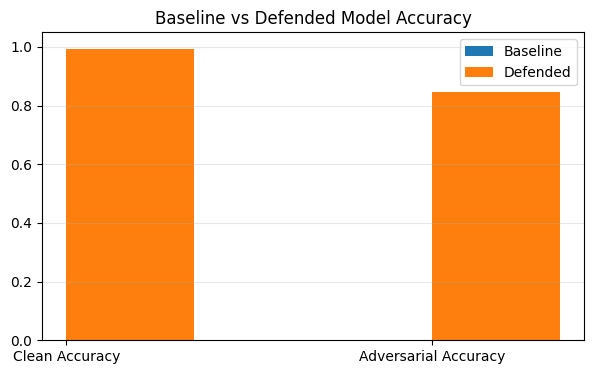

In [9]:
baseline_clean = None
baseline_adv = None
if os.path.exists(BASELINE_METRICS_PATH):
    with open(BASELINE_METRICS_PATH) as f:
        baseline_json = json.load(f)
        baseline_clean = baseline_json.get('clean_accuracy', None)
        baseline_adv = baseline_json.get('fgsm_accuracy', None)


labels = ['Clean Accuracy', 'Adversarial Accuracy']
before = [baseline_clean if baseline_clean is not None else np.nan, baseline_adv if baseline_adv is not None else np.nan]
after = [clean_acc, adv_acc]


import matplotlib.pyplot as plt
x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - width/2, before, width, label='Baseline')
plt.bar(x + width/2, after, width, label='Defended')
plt.xticks(x, labels)
plt.ylim(0, 1.05)
plt.title('Baseline vs Defended Model Accuracy')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.savefig(os.path.join(OUT_DIR, 'comparison_plot.png'), dpi=150)
plt.show()

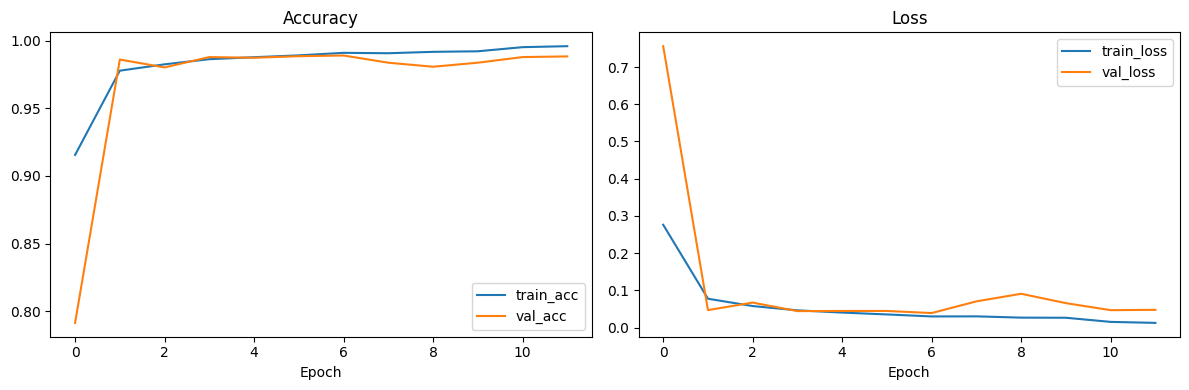

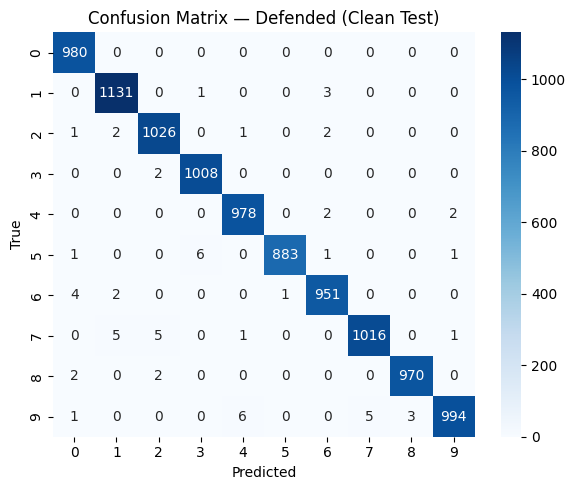

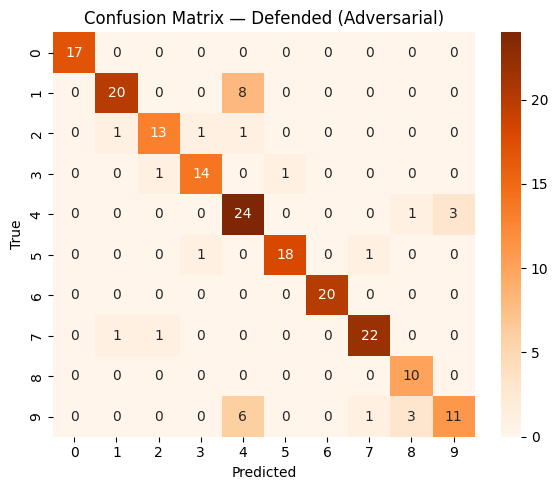

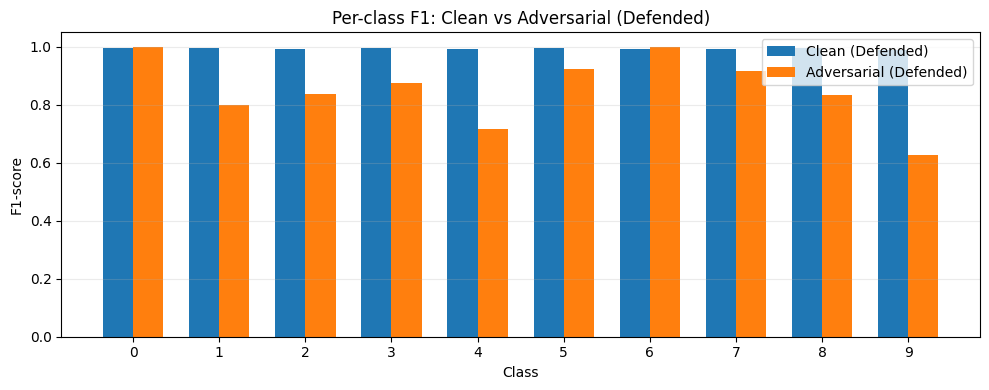

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


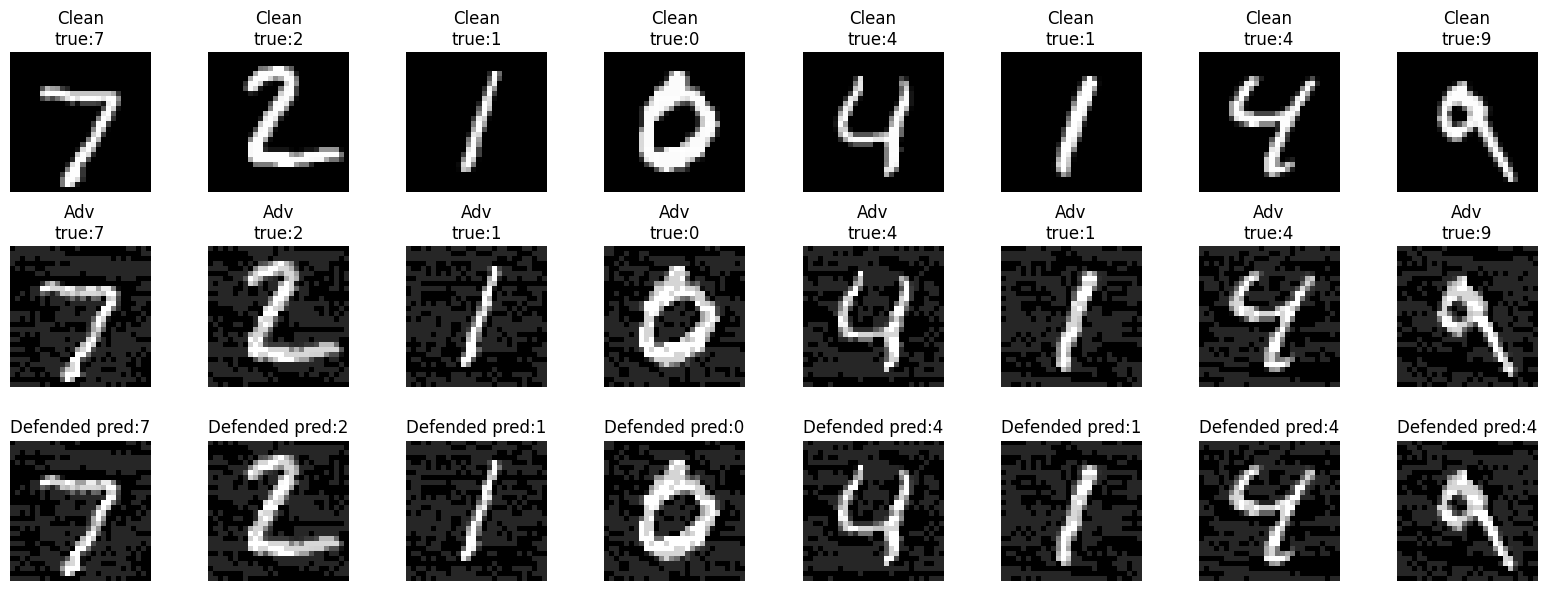


Saved visualization files in: /kaggle/working/defense_outputs
 - cm_defended_adv.npy
 - cm_defended_adv_heatmap.png
 - cm_defended_clean.npy
 - cm_defended_clean_heatmap.png
 - comparison_plot.png
 - cr_defended_adv.json
 - cr_defended_clean.json
 - defended_history.json
 - defense_summary.json
 - per_class_f1_defended.png
 - sample_comparison_defended.png
 - training_curves.png


In [10]:

import os, json, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

OUT_DIR = "/kaggle/working/defense_outputs"
os.makedirs(OUT_DIR, exist_ok=True)


history_path = os.path.join(OUT_DIR, "defended_history.json")
if os.path.exists(history_path):
    with open(history_path) as f:
        hist = json.load(f)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(hist.get("accuracy", []), label="train_acc")
    axs[0].plot(hist.get("val_accuracy", []), label="val_acc")
    axs[0].set_title("Accuracy")
    axs[0].set_xlabel("Epoch"); axs[0].legend()

    axs[1].plot(hist.get("loss", []), label="train_loss")
    axs[1].plot(hist.get("val_loss", []), label="val_loss")
    axs[1].set_title("Loss")
    axs[1].set_xlabel("Epoch"); axs[1].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "training_curves.png"), dpi=150)
    plt.show()
else:
    print("No defended_history.json found at", history_path)


cm_clean_path = os.path.join(OUT_DIR, "cm_defended_clean.npy")
cm_adv_path   = os.path.join(OUT_DIR, "cm_defended_adv.npy")

if os.path.exists(cm_clean_path):
    cmc = np.load(cm_clean_path)
    plt.figure(figsize=(6,5))
    sns.heatmap(cmc, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix — Defended (Clean Test)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "cm_defended_clean_heatmap.png"), dpi=150)
    plt.show()
else:
    print("No cm_defended_clean.npy at", cm_clean_path)

if os.path.exists(cm_adv_path):
    cma = np.load(cm_adv_path)
    plt.figure(figsize=(6,5))
    sns.heatmap(cma, annot=True, fmt="d", cmap="Oranges")
    plt.title("Confusion Matrix — Defended (Adversarial)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "cm_defended_adv_heatmap.png"), dpi=150)
    plt.show()
else:
    print("No cm_defended_adv.npy at", cm_adv_path)


cr_clean_path = os.path.join(OUT_DIR, "cr_defended_clean.json")
cr_adv_path   = os.path.join(OUT_DIR, "cr_defended_adv.json")

if os.path.exists(cr_clean_path) and os.path.exists(cr_adv_path):
    with open(cr_clean_path) as f:
        cr_clean = json.load(f)
    with open(cr_adv_path) as f:
        cr_adv = json.load(f)

    classes = [str(i) for i in range(10)]
    f1_clean = [cr_clean[c]["f1-score"] if c in cr_clean else 0.0 for c in classes]
    f1_adv   = [cr_adv[c]["f1-score"] if c in cr_adv else 0.0 for c in classes]

    x = np.arange(len(classes)); width = 0.35
    plt.figure(figsize=(10,4))
    plt.bar(x - width/2, f1_clean, width, label="Clean (Defended)")
    plt.bar(x + width/2, f1_adv,   width, label="Adversarial (Defended)")
    plt.xticks(x, classes); plt.ylabel("F1-score"); plt.xlabel("Class")
    plt.title("Per-class F1: Clean vs Adversarial (Defended)")
    plt.legend(); plt.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "per_class_f1_defended.png"), dpi=150)
    plt.show()
else:
    print("Classification reports not found for per-class F1 chart")


try:
    if "defended" in globals() and "x_adv" in globals() and "x_test" in globals():
        n = min(8, len(x_adv), len(x_test))
        fig, axs = plt.subplots(3, n, figsize=(n*2, 6))
        for i in range(n):
            axs[0,i].imshow(x_test[i].squeeze(), cmap="gray")
            axs[0,i].set_title(f"Clean\ntrue:{y_test[i]}")
            axs[0,i].axis("off")

            axs[1,i].imshow(x_adv[i].squeeze(), cmap="gray")
            axs[1,i].set_title(f"Adv\ntrue:{y_adv[i]}")
            axs[1,i].axis("off")

            pred = np.argmax(defended.predict(np.expand_dims(x_adv[i],0)), axis=1)[0]
            axs[2,i].imshow(x_adv[i].squeeze(), cmap="gray")
            axs[2,i].set_title(f"Defended pred:{pred}")
            axs[2,i].axis("off")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, "sample_comparison_defended.png"), dpi=150)
        plt.show()
    else:
        print("defended model or x_adv/x_test not in kernel; run evaluation cells first")
except Exception as e:
    print("Error generating sample grid:", e)


print("\nSaved visualization files in:", OUT_DIR)
for fname in sorted(os.listdir(OUT_DIR)):
    if fname.endswith((".png", ".npy", ".json")):
        print(" -", fname)


